# Gesture Based Visually Writing System: Adding Virtual GUI

## Contents
* [Before Everything Starts](#Before-Everything-Starts)
* [Credits](#Credits)
* [How am i here?](#How-am-i-here?)
* [Introduction](#Introduction)
* [Derive Concepts](#Derive-Concepts)
* [Prepare Icons](#Prepare-Icons)
* [Create ROI For VUI on Frame](#Create-ROI-for-VUI-on-frame)
* [Working on Contours](#Working-on-Contours)
    * [Current Codes](#Current-Codes)
* [Inserting Icons on Canvas](#Inserting-Icons-on-Canvas)
* [Combining VUI and Draw UI](#Combining-VUI-and-Draw-UI)
* [Show me the codes.](#What-did-i-do?)
* [Bonus Topic](#Bonus-Topic)
* [What next?](#What-next?)

## Before Everything Starts
Well, before proceeding further, it is very important that you follow the previous blog where every concepts and codes are described from scratch level. I am adding a new feature here on the existing project so it will be a very great idea to understand the working mechanism of the existing system. Please go through below article if you have not read it.
* [Gesture Based Visually Writing System Using OpenCV and Python](https://acharyaramkrishna.com.np/2020/08/01/gesture-based-visually-writing-system-using-opencv-and-python/)

## Credits
I want to give full credits to the readers (even if 1 person have read it) of previous blog and the current readers like you. 

## Introduction
The introduction dates back to the previous article, where i did some basic writings just by moving fingers in front of the camera. Last time, i was able to do below things with keyboard keys.
* `escape`:- Exit from system.
* `space`:- Save current drawing(excluding pointer).
* `z`:- Idle mode(move only pointer).
* `x`:- Erase mode.
* `c`:- Color mode.
* `e`:- Erase current canvas but leave the average image.
* `r`:- Restart the average and canvas.

Now i want to try something new here. <b> As for writing this blog, i have not done any coding on this topic but if you read further you might be able to know what did i accomplish throughout the end.</b> I want the system to run without the need of keyboard(i am just assuming here). 

Last time i wrote a system that can perform above tasks and on bonus topic, i passed the drawn character to [Devanagari Handwritten Character/Word Detector](https://acharyaramkrishna.com.np/2020/02/25/building-ocr-for-devanagari-handwritten-character/) and showed the predicted text. 
## How am i here?
How i got the idea to perform this project? I don't know but something like, "Once i was writing something on my paper and then ink on the pen finished, and i was not able to write more because i had no spare pens. Also shop is far from village. Then i got an idea, can i replace the pen just for some moments?" Well it is just a funny story. But truth is, me and my friend was about to do some academic research. We have to think many topics and one of mine choice is here. This topic is rejected so i am here, to make it work.

## Derive Concepts
Now on this blog, i would like to make a simple virtual GUI (i would like to call it <b>Virtual User Interface</b>), that can be controlled by just moving fingers in front of the camera. It will not be a real GUI but it will be shown on some side of the frame. We will move our finger to those part and we can actually perform some tasks. While writing this, i have not proceeded towards code so lets see where the boat takes. 

I want to make some assumptions here what type of the system i am hoping it to be?
* Current system:
<img src="Assets/detection.png"/>

* Now i want new System to be like below(sketched form)
<img src="Assets/guiconcept.png">

## Prepare Icons
I am only working on making GUI like panel for previously completed modes. Which means exit, save current draw, idle, draw, erase, pass to detector, erase canvas, restart system. So to make icons, i am going to work on paint. Make a black background and draw icons on it. As always black color is identity additive on Image Processing world so lets get into it. I am making an folder named `Icons` on working directory and saving all icons there. The image will be 301 by 299 dimension PNG image (originally was trying to make (300, 300) but paint betrayed me).
* Exit
<img src="icons/exit.png">

* Save drawing
<img src="icons/save.png">

* Idle/move
<img src="icons/move.png">

* Draw
<img src = "icons/draw.png">

* Erase
<img src="icons/erase.png">

* Detection
<img src="icons/detect.png">

* Clear Canvas
<img src="icons/clear.png">

* Restart system
<img src="icons/restart.png">

### Lets try to combine these icons to make them appear on canvas

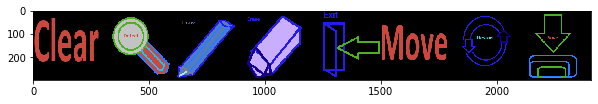

In [73]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show(img, figsize=(10, 10)):
    figure = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

# read icons
icon_dir = "icons/"
icons = []
for image_name in os.listdir(icon_dir):
    icons.append(cv2.imread(icon_dir+image_name))

icons = np.array(icons)
shape = icons.shape
# create an new image where all these icons are stackked
icons_holder = np.zeros((shape[1], shape[0]*shape[2], shape[3]))
#print(icons_holder.shape)

for i, icon in enumerate(icons):
    icons_holder[:, shape[2]*i : shape[2]*(i+1), :] = icon

icons_holder = icons_holder.astype(np.uint8)
show(icons_holder)

* First we read icons and store them on list.
* Then make array of icons.
* Then make a new array where we will attach icons horizontally.
* To make attach like image, we performed some indexing. (But NumPy's hstack can do this easily.)
* Finally make that attached image `uint8`, because OpenCV expects this so.

## Create ROI for VUI on frame
Lets take codes from previous blog and work here. So we have total 8 icons, we want to divide the total of ROI made for VUI on 8 vertical parts. What i mean is i will divide the ROI parts on equal 8 parts and each parts will be for individual icons. First let me update the code little bit. I am going to wrap everthing under a method here. Method named `run_system` will wrap everything. Below code performs the drawing of ROI for GUI. <b>Note that the code below is little bit modified version of previous blog's.</b>


In [74]:
import imutils
import time
from dcr.recognition import *

def running_average(bg_img, image, aweight):
    if bg_img is None:
        bg_img = image.copy().astype("float")
    else:
        cv2.accumulateWeighted(image, bg_img, aweight)    
    return bg_img

def get_contours(bg_img, image, threshold=10):
    
    # abs diff betn img and bg
    diff = cv2.absdiff(bg_img.astype("uint8"), image)    
    _, th = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    (cnts, _) = cv2.findContours(th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(cnts) == 0:
        return None
    else:
        max_cnt = max(cnts, key=cv2.contourArea)
        return th, max_cnt

def run_system():
    #accumulate weight variable
    aweight = 0.5
    # strat the camera
    cam = cv2.VideoCapture(0)
    # ROI box
    top, right, bottom, left = 250, 400, 480, 640

    # ROI for GUI
    gtop, gright, gbottom, gleft = 150, 400, 240, 670
    gcolors = np.random.randint(0, 255, (9, 3), dtype=np.uint32).tolist()
    gb_indices = int((gleft-gright)/9)
    gb_indices = np.arange(gright, gleft, gb_indices)

    # count frame
    num_frames=0
    # writing canvas
    canvas = None
    # thickness
    t=3
    # draw color(ink color)
    draw_color = (0, 255, 0)
    # pointer color
    pointer_color = (255, 0, 0)
    # mode flag
    erase = False
    # flag to indicate take average
    take_average=True
    #bg image
    bg_img=None
    # loop while everything is true
    while True:
        # read the camera result
        (ret, frame) = cam.read()
        # if camera has read frame
        if ret:
            # wait for 1ms to key press
            key = cv2.waitKey(1) & 0xFF
            frame = imutils.resize(frame, width=700)
            # flip to remove mirror effect
            frame = cv2.flip(frame, 1)
            # clone it to not mess with real frame
            clone = frame.copy()
            h, w = frame.shape[:2]
            # take roi, to send it onto contour/average extraction
            roi = frame[top:bottom, right:left]
            # roi to grayscale
            gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            # add GaussianBlur to eliminate some noise
            gray = cv2.GaussianBlur(gray, (7, 7), 0)

            # if to take average and num frames on average taking is lesser than 
            if num_frames<100 and take_average==True:
                # perform running average
                bg_img = running_average(bg_img, gray, aweight)
                # put frame number on frame
                cv2.putText(clone, str(num_frames), (100, 100),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 1)
                num_frames+=1
            # if not to take average
            else:
                num_frames=0                        
                # take our segmented hand
                hand = get_contours(bg_img, gray)
                take_average=False
                if hand is not None:

                    # if pressed x, erase
                    if chr(key) == "x":
                        draw_color = (255, 255, 255)
                        pointer_color = (0, 0, 255)
                        erase = True
                    if chr(key) == "c":
                        draw_color = (0, 255, 0)
                        pointer_color = (255, 0, 0)
                        erase = False
                    #idle
                    if chr(key) == "z":
                        erase = None
                        pointer_color = (0, 0, 0)                   
                    # restart system
                    if chr(key) == "r":
                        take_average=True
                        canvas = None
                    if chr(key) == "e":
                        canvas = None
                        drawn = np.zeros(drawn.shape)+255



                    thresholded, segmented = hand
                    cv2.drawContours(clone, [segmented+(right,top)], -1, (0, 0, 255))   

                    tshape = thresholded.shape
                    sshape = segmented.shape
                    new_segmented = segmented.reshape(sshape[0], sshape[-1])
                    m = new_segmented.min(axis=0)

                    if type(canvas) == type(None):
                        canvas = np.zeros((tshape[0], tshape[1], 3))+255

                    c = np.zeros(canvas.shape, dtype=np.uint8)
                    cv2.circle(c, (m[0], m[1]), 5, pointer_color, -3)
                    cv2.circle(clone, (right+m[0], top+m[1]), 5, pointer_color, -3)

                    if erase==True:
                        cv2.circle(canvas, (m[0], m[1]), 5, draw_color, -3)
                        erimg=cv2.circle(canvas.copy(), (m[0], m[1]), 5, (0, 0, 0), -3)            
                        cv2.circle(c, (m[0], m[1]), 5, (0, 0, 255), -3)
                        e = cv2.erode(erimg, (3, 3), iterations=5)
                        drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                        c = cv2.resize(c, (clone.shape[1], clone.shape[0]))
                        drawn_new = drawn+c
                        cv2.imshow("Drawing", drawn+c)
                        erimg=cv2.circle(canvas.copy(), (m[0], m[1]), 5, (255, 255, 255), -3)            
                        cv2.circle(c, (m[0], m[1]), 5, (0, 0, 255), -3)
                        e = cv2.erode(erimg, (3, 3), iterations=5)
                        drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))                    
                    elif erase==False:
                        #cv2.imshow("Thresholded", c)
                        cv2.circle(canvas, (m[0], m[1]), 5, draw_color, -3)
                        e = cv2.erode(canvas, (3, 3), iterations=5)
                        drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                        c = cv2.resize(c, (clone.shape[1], clone.shape[0]))
                        drawn_new = drawn+c
                        cv2.imshow("Drawing", drawn+c)
                    elif erase == None:
                        canvas_shape = canvas.shape
                        clone_shape = clone.shape
                        eshape = (clone_shape[0]/canvas_shape[0], clone_shape[1]/canvas_shape[1])
                        m[0] = int(eshape[1]*m[0])
                        m[1] = int(eshape[0]*m[1])
                        drawn = cv2.resize(drawn, (clone.shape[1], clone.shape[0]))
                        dc = drawn.copy()  
                        cv2.circle(dc, (m[0], m[1]), 10, pointer_color, -3)

                        cv2.imshow("Drawing", dc)

            if chr(key) == "s":
                show(drawn)
                d = drawn.copy().astype(np.uint8) 
                r = recognition(cv2.cvtColor(d, cv2.COLOR_BGR2GRAY), 'show')
                cv2.imshow("Detection", r)

            # draw a ROI for Draw
            cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)

            cv2.putText(clone, str("GUI ROI"), (400, 140),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

            # draw a ROI for GUI
            for i in range(len(gb_indices)-1):
                gleft = gb_indices[i]
                gright = gb_indices[i+1]
                cv2.rectangle(clone, (gleft, gtop), (gright, gbottom), gcolors[i], 3)

            # show live feed
            cv2.imshow("Feed", clone)
            if key == 32:
                cv2.imwrite("Captured.png", clone)
            # if pressed  escape, loop out and stop processing
            if key==27:
                break
    cam.release()
    cv2.destroyAllWindows()
run_system()
            

Now the running frame must look like below. May be the color on box is little confusing.
<img src="Assets/GUIROI.png">

## Working on Contours
Now we have to deal with contours for Draw ROI and GUI ROI. And we have made a GUI ROI just above the Draw ROI hence we have to deal with only one at a time. But problem arises when we try to interact on GUI regions because our hand part will also fall on Draw ROI at the same time. Hence we must define some rule that when contours have been detected on GUI ROI then ignore contours on Draw ROI. Lets first work on that.

To get contours for drawing and interactive VUI(Virtual User Interface), we have to pass the cropped ROI for both. Hence we will check for contours twice. First, check if contours have been detected on VUI if yes then try to change working modes. If not then work on canvas with existing mode. The process of getting contours is same for both. But variable names has been changed and i have tried to make it as friendly as possible. Also don't forget to the part where boxes were defined.

```python
def run_system():
    ###################
    ###################
    # ROI for GUI
    gtop, gright, gbottom, gleft = 150, 400, 240, 681
    gcolors = np.random.randint(0, 255, (9, 3), dtype=np.uint32).tolist()
    gb_indices = int((gleft-gright)/8)
    gb_indices = np.arange(gright, gleft, gb_indices)
    gb_indices[-1] = gb_indices[-1]+1
    # take each box's y coordinates
    # read icons
    icon_dir = "icons/"
    icons = []
    for image_name in os.listdir(icon_dir):
        icons.append(cv2.imread(icon_dir+image_name))
    icons = np.array(icons)
    
    gui_boxes = [(gb_indices[i], gb_indices[i+1]) for i in range(len(gb_indices)-1)]
    modes = os.listdir("icons/")
    modes = [mode.split(".")[0] for mode in modes]
    gui_modes_position = {modes[i]:gui_boxes[i] for i in range(len(gb_indices)-1)}
    gui_modes_icons = {modes[i]:icons[i] for i in range(len(gb_indices)-1)}
    print(len(gui_boxes))
```
The ROI boxes has been changed from previous step. <b>Please make sure you make the ROI box exactly same.</b> 
* I also made rightmost index same as `gleft` because to handle contours appearing on exactly at `681` column. 
* Then i also prepared icons that we will be using. Variable `icons` will hold all icons as array. 
* Then i made a list to hold verticle extreme positions of each VUI boxes, in other words, position of opposite breadths. 
* Then i took the name of mode from the icon names, it is much easier than manually writing. 
* Then two different dictionaries holds the key as mode name and value as icon image and box's positions.

### Running Averages
Since we are dealing with two different ROIs from different portion of an frame, we definitely need 2 averages for respective ROIs. For drawing, variable names are either started with `d` or `draw` and for VUI, variable name started with `g` or `gui`. For example, for grayscale draw, `draw_gray`. So the current code inside `run_system`'s taking average part looks like below:

```python
def run_system():
    #########################
    #########################
    while True:
        ######################
        ######################
            # clone it to not mess with real frame
            clone = frame.copy()
            gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
            h, w = frame.shape[:2]
            # take roi, to send it onto contour/average extraction
            draw_roi = frame[top:bottom, right:left]
            # roi to grayscale
            #draw_gray = cv2.cvtColor(draw_roi, cv2.COLOR_BGR2GRAY)
            draw_gray = gray[top:bottom, right:left]
            # add GaussianBlur to eliminate some noise
            draw_gray = cv2.GaussianBlur(draw_gray, (7, 7), 0)
            
            
            gui_roi = frame[gtop:gbottom, gright:gleft]
            #gui_gray = cv2.cvtColor(gui_roi, cv2.COLOR_BGR2GRAY)
            gui_gray = gray[gtop:gbottom, gright:gleft]
            gui_gray = cv2.GaussianBlur(gui_gray, (7, 7), 0)
            
            # if to take average and num frames on average taking is lesser than 
            if num_frames<100 and take_average==True:
                # perform running average
                draw_bg = running_average(draw_bg, draw_gray, aweight)
                #print(gui_gray)
                #if gui_gray is not None:
                gui_bg = running_average(gui_bg, gui_gray, aweight=aweight)
                # put frame number on frame
                cv2.putText(clone, str(num_frames), (100, 100),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 1)
                num_frames+=1
            # if not to take average
```

### Getting Contours from VUI
As usual, we pass our backgroud (averaged) image and then the grayscale current ROI, and take the absolute difference inside method `get_contours`. What is new here is that we are performing two `get_contours` because we have 2 ROIs. 

First, we took contours for VUI by passing `gui_bg` and `gui_gray` to `get_contours` then we did same for `draw`. Then we proceed to check if contours were present on VUI regions. Same as previous code we took contour's extreme position (for drawing, minimum was taken). Then we have to find that on which box was the contour detected. Since each box on VUI ROI has distinctive purpose, it is very necessary to calculate it properly. So to make is more precise, i came up with an idea. If same mode occurs on more than curtain times then work on this mode else don't change the mode. For simplicity i am checking on 5 consecutive frames only.

```python
def run_system(count_mode=5):
    #########################
    #########################
    # to count number of time current mode selected without intrusion
    count_modes = 0
    while True:
        ######################
        ######################
            # if not to take average
            else:
                #show(gui_bg)
                num_frames=0                        
                # take our segmented hand
                gui_hand = get_contours(gui_bg, gui_gray)
                draw_hand = get_contours(draw_bg, draw_gray)
                take_average=False
                
                if gui_hand is not None:
                    # get the position of contours
                    gthresholded, gsegmented = gui_hand
                    cv2.drawContours(clone, [gsegmented+(gright,gtop)], -1, (0, 0, 255))   
                    original_gcontour = gsegmented + (gright, gtop)
                    
                    tshape = gthresholded.shape
                    sshape = gsegmented.shape
                    new_segmented = original_gcontour.reshape(sshape[0], sshape[-1])
                    m = new_segmented.max(axis=0)
                    #print(m)
                    
                    # check if the y axis lies on any of gui boxes
                    current_box = [box for box in gui_boxes if box[0] <= m[0] <= box[1]][0] 
                    #print(current_box, m)
                    current_mode = [mode for mode, pos in gui_modes_position.items() if current_box==pos][0]
                    #print(current_mode)
                    
                    if current_mode == previous_mode:
                        count_modes += 1
                    if count_modes > count_mode:
                        running_mode = current_mode
                        #count_modes = 0
                    previous_mode = current_mode

```

I am only going to explain what is happening from `current_box = [box for box in gui_boxes if box[0] <= m[0] <= box[1]][0] `. 
* First take the extreme contour and get the range (on `gui_boxes`) where this lies.
* Next get the mode name using the range found on above step.
* Next if current mode and previous mode are same then we increase the count modes.
* If count modes is equal to count mode then we change the running mode.
* On end of every step, we change previous mode as current mode.

<b>Note that, `count_modes` has to be made 0 at some point else the counting will not be valid.</b>

### Working on Draw Contours

```python
def run_system(count_mode=5):
    #########################
    #########################
    while True:
        #####################
        #####################
        if ret:
            #####################
            #####################
            else:
                ###################
                ###################
                if gui_hand is not None:
                    #######################
                    #######################
                    previous_mode = current_mode
                   
                if gui_hand is None and draw_hand is not None:
                    # if pressed x, erase
                    if chr(key) == "x" or running_mode=="erase":
                        draw_color = (255, 255, 255)
                        pointer_color = (0, 0, 255)
                        erase = True
                    if chr(key) == "c" or running_mode=="draw":
                        draw_color = (0, 255, 0)
                        pointer_color = (255, 0, 0)
                        erase = False
                    #idle
                    if chr(key) == "z" or running_mode=="move":
                        erase = None
                        pointer_color = (0, 0, 0)                   
                    # restart system
                    if chr(key) == "r" or running_mode == "restart":
                        take_average=True
                        running_mode = "move"
                        canvas = None
                    if chr(key) == "e" or running_mode == "clear":
                        canvas = None
                        drawn = np.zeros(drawn.shape)+255
                        running_mode="move"

```

So nothing extraordinary is happening here besides some simple things. We still want our keys to work so we are adding our `running_mode` check on the side of key checking. For `erase`, `draw`, `move` we don't have to change the running mode but when we restarted, then change running mode to `move` and also on `clear` mode.

### Current Codes
Current version of `run_system` must look like below. 
```python
def run_system(count_mode=5):
    #accumulate weight variable
    aweight = 0.5
    # strat the camera
    cam = cv2.VideoCapture(0)
    # ROI box
    top, right, bottom, left = 250, 400, 480, 640

    # ROI for GUI
    gtop, gright, gbottom, gleft = 150, 400, 240, 681
    gcolors = np.random.randint(0, 255, (9, 3), dtype=np.uint32).tolist()
    gb_indices = int((gleft-gright)/8)
    gb_indices = np.arange(gright, gleft, gb_indices)
    gb_indices[-1] = gb_indices[-1]+1
    # take each box's y coordinates
    # read icons
    icon_dir = "icons/"
    icons = []
    for image_name in os.listdir(icon_dir):
        icons.append(cv2.imread(icon_dir+image_name))
    icons = np.array(icons)
    
    gui_boxes = [(gb_indices[i], gb_indices[i+1]) for i in range(len(gb_indices)-1)]
    modes = os.listdir("icons/")
    modes = [mode.split(".")[0] for mode in modes]
    gui_modes_position = {modes[i]:gui_boxes[i] for i in range(len(gb_indices)-1)}
    gui_modes_icons = {modes[i]:icons[i] for i in range(len(gb_indices)-1)}
    print(len(gui_boxes))
    
    #print(gb_indices, gui_boxes, modes)
    # count frame
    num_frames=0
    # writing canvas
    canvas = None
    # thickness
    t=3
    # draw color(ink color)
    draw_color = (0, 255, 0)
    # pointer color
    pointer_color = (255, 0, 0)
    # mode flag
    erase = False
    # flag to indicate take average
    take_average=True
    #bg image
    draw_bg=None
    gui_bg = None
    
    previous_mode = "move"
    running_mode = "move"
    drawn = None
    count_modes = 0
    # loop while everything is true
    while True:
        # read the camera result
        (ret, frame) = cam.read()
        # if camera has read frame
        if ret:
            # wait for 1ms to key press
            key = cv2.waitKey(1) & 0xFF
            frame = imutils.resize(frame, width=700)
            # flip to remove mirror effect
            frame = cv2.flip(frame, 1)
            # clone it to not mess with real frame
            clone = frame.copy()
            gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
            h, w = frame.shape[:2]
            # take roi, to send it onto contour/average extraction
            draw_roi = frame[top:bottom, right:left]
            # roi to grayscale
            #draw_gray = cv2.cvtColor(draw_roi, cv2.COLOR_BGR2GRAY)
            draw_gray = gray[top:bottom, right:left]
            # add GaussianBlur to eliminate some noise
            draw_gray = cv2.GaussianBlur(draw_gray, (7, 7), 0)
            
            
            gui_roi = frame[gtop:gbottom, gright:gleft]
            #gui_gray = cv2.cvtColor(gui_roi, cv2.COLOR_BGR2GRAY)
            gui_gray = gray[gtop:gbottom, gright:gleft]
            gui_gray = cv2.GaussianBlur(gui_gray, (7, 7), 0)
            
            # if to take average and num frames on average taking is lesser than 
            if num_frames<100 and take_average==True:
                # perform running average
                draw_bg = running_average(draw_bg, draw_gray, aweight)
                #print(gui_gray)
                #if gui_gray is not None:
                gui_bg = running_average(gui_bg, gui_gray, aweight=aweight)
                # put frame number on frame
                cv2.putText(clone, str(num_frames), (100, 100),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 1)
                num_frames+=1
            # if not to take average
            else:
                #show(gui_bg)
                num_frames=0                        
                # take our segmented hand
                gui_hand = get_contours(gui_bg, gui_gray)
                draw_hand = get_contours(draw_bg, draw_gray)
                take_average=False
                
                if gui_hand is not None:
                    # get the position of contours
                    gthresholded, gsegmented = gui_hand
                    cv2.drawContours(clone, [gsegmented+(gright,gtop)], -1, (0, 0, 255))   
                    original_gcontour = gsegmented + (gright, gtop)
                    
                    tshape = gthresholded.shape
                    sshape = gsegmented.shape
                    new_segmented = original_gcontour.reshape(sshape[0], sshape[-1])
                    m = new_segmented.max(axis=0)
                    #print(m)
                    
                    # check if the y axis lies on any of gui boxes
                    current_box = [box for box in gui_boxes if box[0] <= m[0] <= box[1]][0] 
                    #print(current_box, m)
                    current_mode = [mode for mode, pos in gui_modes_position.items() if current_box==pos][0]
                    #print(current_mode)
                    
                    if current_mode == previous_mode:
                        count_modes += 1
                    if count_modes > count_mode:
                        running_mode = current_mode
                        #count_modes = 0
                    previous_mode = current_mode
                   
                    
                if gui_hand is None and draw_hand is not None:

                    # if pressed x, erase
                    if chr(key) == "x" or running_mode=="erase":
                        draw_color = (255, 255, 255)
                        pointer_color = (0, 0, 255)
                        erase = True
                    if chr(key) == "c" or running_mode=="draw":
                        draw_color = (0, 255, 0)
                        pointer_color = (255, 0, 0)
                        erase = False
                    #idle
                    if chr(key) == "z" or running_mode=="move":
                        erase = None
                        pointer_color = (0, 0, 0)                   
                    # restart system
                    if chr(key) == "r" or running_mode == "restart":
                        take_average=True
                        running_mode = "move"
                        canvas = None
                    if chr(key) == "e" or running_mode == "clear":
                        canvas = None
                        drawn = np.zeros(drawn.shape)+255
                        running_mode="move"


                    dthresholded, dsegmented = draw_hand
                    cv2.drawContours(clone, [dsegmented+(right,top)], -1, (0, 0, 255))   

                    tshape = dthresholded.shape
                    sshape = dsegmented.shape
                    new_segmented = dsegmented.reshape(sshape[0], sshape[-1])
                    m = new_segmented.min(axis=0)

                    if type(canvas) == type(None):
                        canvas = np.zeros((tshape[0], tshape[1], 3))+255

                    c = np.zeros(canvas.shape, dtype=np.uint8)
                    cv2.circle(c, (m[0], m[1]), 5, pointer_color, -3)
                    cv2.circle(clone, (right+m[0], top+m[1]), 5, pointer_color, -3)

                    if erase==True:
                        cv2.circle(canvas, (m[0], m[1]), 5, draw_color, -3)
                        erimg=cv2.circle(canvas.copy(), (m[0], m[1]), 5, (0, 0, 0), -3)            
                        cv2.circle(c, (m[0], m[1]), 5, (0, 0, 255), -3)
                        e = cv2.erode(erimg, (3, 3), iterations=5)
                        drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                        c = cv2.resize(c, (clone.shape[1], clone.shape[0]))
                        drawn_new = drawn+c
                        cv2.imshow("Drawing", drawn+c)
                        erimg=cv2.circle(canvas.copy(), (m[0], m[1]), 5, (255, 255, 255), -3)            
                        cv2.circle(c, (m[0], m[1]), 5, (0, 0, 255), -3)
                        e = cv2.erode(erimg, (3, 3), iterations=5)
                        drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))                    
                    elif erase==False:
                        #cv2.imshow("Thresholded", c)
                        cv2.circle(canvas, (m[0], m[1]), 5, draw_color, -3)
                        e = cv2.erode(canvas, (3, 3), iterations=5)
                        drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                        c = cv2.resize(c, (clone.shape[1], clone.shape[0]))
                        drawn_new = drawn+c
                        cv2.imshow("Drawing", drawn+c)
                    elif erase == None:
                        canvas_shape = canvas.shape
                        clone_shape = clone.shape
                        eshape = (clone_shape[0]/canvas_shape[0], clone_shape[1]/canvas_shape[1])
                        m[0] = int(eshape[1]*m[0])
                        m[1] = int(eshape[0]*m[1])
                        
                        if drawn is None:
                            e = cv2.erode(canvas, (3, 3), iterations=5)
                            drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                        
                        drawn = cv2.resize(drawn, (clone.shape[1], clone.shape[0]))
                        dc = drawn.copy()  
                        cv2.circle(dc, (m[0], m[1]), 10, pointer_color, -3)

                        cv2.imshow("Drawing", dc)

            if chr(key) == "s" or running_mode=="detect":
                show(drawn)
                d = drawn.copy().astype(np.uint8) 
                r = recognition(cv2.cvtColor(d, cv2.COLOR_BGR2GRAY), 'show')
                cv2.imshow("Detection", r)
                running_mode="move"

            # draw a ROI for Draw
            cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)

            cv2.putText(clone, str("GUI ROI"), (400, 140),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
            cv2.putText(clone, running_mode, (400, 100),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

            # draw a ROI for GUI
            for i in range(len(gb_indices)-1):
                _gleft = gb_indices[i]
                _gright = gb_indices[i+1]
                cv2.rectangle(clone, (_gleft, gtop), (_gright, gbottom), gcolors[i], 3)
                cv2.putText(clone, modes[i][:2], (_gleft+2, int((gtop+gbottom)/2)),
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.75, gcolors[i], 2)
            # show live feed
            cv2.imshow("Feed", clone)
            if key == 32 or running_mode=="save":
                cv2.imwrite("Captured.png", clone)
                running_mode = "move"
            # if pressed  escape, loop out and stop processing
            if key==27 or running_mode=="exit":
                break
    cam.release()
    cv2.destroyAllWindows()
run_system()
```
#### Points to focus:-
* We also had to initialize `drawn` to be `None`.
* We made each VUI box work for distinctive mode.
* We showed VUI boxes on running frame.
* We also showed current running mode on frame (as text).

Your current output should look like below.
<figure>
<video src = "Assets/rVUI1.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Current VUI working</figcaption>
</figure> 

## Inserting Icons on Canvas
Our Current canvas is only made for drawing but not for icons. How can we extend our canvas so that we can make a virtual interaction? 

One idea can be to make width of both VUI ROI and Draw ROI same. 
* And then prepare a separate canvas for VUI. 
* Then showing pointer like effects on there too.
* Then adding or stacking that above the drawing canvas.

Will it work? Lets see.

### Imporvements
* While taking contours on VUI, take minimum value instead of maximum.
```python
                    m = new_segmented.min(axis=0)
```

* Also draw a circle on frame at the top most position. (The topmost position will have least value because our perception of top and image's top are upside different.)
```python
                    ###############################
                    ###############################
                    previous_mode = current_mode
                    cv2.circle(clone, (m[0], m[1]), 10, pointer_color, -3)
```

### Creating Canvas for VUI

```python
                    previous_mode = current_mode
                    
                    if vui_canvas is None:
                        gshape = gray.shape
                        vui_canvas = cv2.resize(icons_holder, (gshape[1], 100)).astype(np.uint8)
                        vshape = vui_canvas.shape
                        vui = np.zeros_like(frame)
                        vui[:100, :] = vui_canvas
                    else:
                        dummy = np.zeros_like(clone)
                        dummy_copy = dummy.copy()
                        dummy[:100, :] += vui_canvas
                        cv2.circle(dummy_copy, (m[0], m[1]), 10, (250, 250, 150), -3)
                        d = dummy_copy[gtop:gbottom, gright:gleft]                                                
                        d = cv2.resize(d, (gshape[1], vshape[0]))
                        
                        dummy_temp = dummy[:100, :]
                        dummy_temp[d!=[0, 0, 0]] = 100
                        dummy[:100, :] += dummy_temp
                        vui = dummy
                        cv2.imshow("vui", vui)
                    cv2.circle(clone, (m[0], m[1]), 10, pointer_color, -3)
                    
```

What is happening above? 
* We initialize our `vui_canvas` on begining of system run.
* Check if `vui_canvas` is `None`, 
    * If it is, then make `icons_holder` on that. 
        * Initialize `vui` (which will be shown to user)
    * Else, we have to make a pointer above the `vui_canvas`
        * To perform that, we make new blank image just like frame and on the top 100 rows, add our `vui_canvas`. It is like pasting something. Above some part.
        * Make copy of dummy image and make circle on it.
        * Crop the same VUI ROI portion from `dummy_copy` (because there lies the pointer).
        * Resize that cropped region to fit our final viewing canvas.
        * Then to make a pointer effect, we take indices where there is not 0s on `dummy_temp` and then change color there.
        * Finally add that portion to original dummy image.
        * Show that VUI.

Now the VUI Canvas must look like below.
<img src="Assets/vuicanvas.png">

I think there are plenty of ideas to perform this operation with lesser line of code and i am really hoping to find it soon.

## Combining VUI and Draw UI
Now that we have succesfully made a VUI and can interact with it like a normal buttons (not really) it is time for us to combine VUI and Draw UI. Draw UI and VUI are both of same shape. if we performed addition then there will not be better visualization. So one have to come with better idea. 

### What did i do?
I used the concept of array stackking. In fact, NumPy's vertical stack came to aid and with its help everything became so easy. But to make it work like a real time, i have modified codes little bit. Please follow your code along with below code.



```python
def run_system(count_mode=5):
    #accumulate weight variable
    aweight = 0.5
    # strat the camera
    cam = cv2.VideoCapture(0)
    # ROI box
    top, right, bottom, left = 250, 400, 480, 681

    # ROI for GUI
    gtop, gright, gbottom, gleft = 150, 400, 240, 681
    gcolors = np.random.randint(0, 255, (9, 3), dtype=np.uint32).tolist()
    gb_indices = int((gleft-gright)/8)
    gb_indices = np.arange(gright, gleft, gb_indices)
    gb_indices[-1] = gb_indices[-1]+1
    # take each box's y coordinates
    # read icons
    icon_dir = "icons/"
    icons = []
    for image_name in os.listdir(icon_dir):
        icons.append(cv2.imread(icon_dir+image_name))
    icons = np.array(icons)
    
    gui_boxes = [(gb_indices[i], gb_indices[i+1]) for i in range(len(gb_indices)-1)]
    modes = os.listdir("icons/")
    modes = [mode.split(".")[0] for mode in modes]
    gui_modes_position = {modes[i]:gui_boxes[i] for i in range(len(gb_indices)-1)}
    gui_modes_icons = {modes[i]:icons[i] for i in range(len(gb_indices)-1)}
    
    # read icons
    icon_dir = "icons/"
    icons = []
    for image_name in os.listdir(icon_dir):
        icons.append(cv2.imread(icon_dir+image_name))

    icons = np.array(icons)
    shape = icons.shape
    # create an new image where all these icons are stackked
    icons_holder = np.zeros((shape[1], shape[0]*shape[2], shape[3]))
     for i, icon in enumerate(icons):
        icons_holder[:, shape[2]*i : shape[2]*(i+1), :] = icon

    icons_holder = icons_holder.astype(np.uint8)
    
    # count frame
    num_frames=0
    # writing canvas
    canvas = None
    # thickness
    t=3
    # draw color(ink color)
    draw_color = (0, 255, 0)
    # pointer color
    pointer_color = (255, 0, 0)
    # mode flag
    erase = False
    # flag to indicate take average
    take_average=True
    #bg image
    draw_bg=None
    gui_bg = None
    
    previous_mode = "move"
    running_mode = "move"
    drawn = None
    count_modes = 0
    vui_canvas = None
    # loop while everything is true
    while True:
        # read the camera result
        (ret, frame) = cam.read()
        # if camera has read frame
        if ret:
            # wait for 1ms to key press
            key = cv2.waitKey(1) & 0xFF
            frame = imutils.resize(frame, width=700)
            # flip to remove mirror effect
            frame = cv2.flip(frame, 1)
            # clone it to not mess with real frame
            clone = frame.copy()
            gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
            h, w = frame.shape[:2]
            # take roi, to send it onto contour/average extraction
            draw_roi = frame[top:bottom, right:left]
            # roi to grayscale
            #draw_gray = cv2.cvtColor(draw_roi, cv2.COLOR_BGR2GRAY)
            draw_gray = gray[top:bottom, right:left]
            # add GaussianBlur to eliminate some noise
            draw_gray = cv2.GaussianBlur(draw_gray, (7, 7), 0)
            
            
            gui_roi = frame[gtop:gbottom, gright:gleft]
            #gui_gray = cv2.cvtColor(gui_roi, cv2.COLOR_BGR2GRAY)
            gui_gray = gray[gtop:gbottom, gright:gleft]
            gui_gray = cv2.GaussianBlur(gui_gray, (7, 7), 0)
            
            if vui_canvas is None:
                gshape = gray.shape
                vui_canvas = cv2.resize(icons_holder, (gshape[1], 100)).astype(np.uint8)
                vshape = vui_canvas.shape
                vui = np.zeros_like(frame)
                vui[:100, :] = vui_canvas
            
            # if to take average and num frames on average taking is lesser than 
            if num_frames<100 and take_average==True:
                # perform running average
                draw_bg = running_average(draw_bg, draw_gray, aweight)                
                gui_bg = running_average(gui_bg, gui_gray, aweight=aweight)
                # put frame number on frame
                cv2.putText(clone, str(num_frames), (100, 100),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 1)
                num_frames+=1
            # if not to take average
            else:
                num_frames=0                        
                # take our segmented hand
                gui_hand = get_contours(gui_bg, gui_gray)
                draw_hand = get_contours(draw_bg, draw_gray)
                take_average=False
                
                if gui_hand is not None:
                    # get the position of contours
                    gthresholded, gsegmented = gui_hand
                    cv2.drawContours(clone, [gsegmented+(gright,gtop)], -1, (0, 0, 255))   
                    original_gcontour = gsegmented + (gright, gtop)
                    
                    tshape = gthresholded.shape
                    sshape = gsegmented.shape
                    new_segmented = original_gcontour.reshape(sshape[0], sshape[-1])
                    m = new_segmented.min(axis=0)
                    # check if the y axis lies on any of gui boxes
                    current_box = [box for box in gui_boxes if box[0] <= m[0] <= box[1]][0] 
                    current_mode = [mode for mode, pos in gui_modes_position.items() if current_box==pos][0]
                    
                    if current_mode == previous_mode:
                        count_modes += 1
                    if count_modes > count_mode:
                        running_mode = current_mode
                    previous_mode = current_mode
                    
                    if vui_canvas is not None:
                        gshape = gray.shape
                        dummy = np.zeros_like(clone)
                        dummy_copy = dummy.copy()
                        dummy[:100, :] += vui_canvas
                        cv2.circle(dummy_copy, (m[0], m[1]), 10, (250, 250, 150), -3)
                        d = dummy_copy[gtop:gbottom, gright:gleft]                                                
                        d = cv2.resize(d, (gshape[1], vshape[0]))                        
                        dummy_temp = dummy[:100, :]
                        dummy_temp[d!=[0, 0, 0]] = 100
                        dummy[:100, :] += dummy_temp
                        vui = dummy
                    cv2.circle(clone, (m[0], m[1]), 10, pointer_color, -3)
                    
                if draw_hand is not None:
                    # if pressed x, erase
                    if chr(key) == "x" or running_mode=="erase":
                        draw_color = (255, 255, 255)
                        pointer_color = (0, 0, 255)
                        erase = True
                    if chr(key) == "c" or running_mode=="draw":
                        draw_color = (0, 255, 0)
                        pointer_color = (255, 0, 0)
                        erase = False
                    #idle
                    if chr(key) == "z" or running_mode=="move":
                        erase = None
                        pointer_color = (0, 0, 0)                   
                    # restart system
                    if chr(key) == "r" or running_mode == "restart":
                        take_average=True
                        running_mode = "move"
                        canvas = None
                    if chr(key) == "e" or running_mode == "clear":
                        canvas = None
                        drawn = np.zeros(drawn.shape)+255
                        running_mode="move"
                    dthresholded, dsegmented = draw_hand
                    cv2.drawContours(clone, [dsegmented+(right,top)], -1, (0, 0, 255))   

                    tshape = dthresholded.shape
                    sshape = dsegmented.shape
                    new_segmented = dsegmented.reshape(sshape[0], sshape[-1])
                    m = new_segmented.min(axis=0)

                    if type(canvas) == type(None):
                        canvas = np.zeros((tshape[0], tshape[1], 3))+255
                    c = np.zeros(canvas.shape, dtype=np.uint8)
                    cv2.circle(c, (m[0], m[1]), 5, pointer_color, -3)
                    cv2.circle(clone, (right+m[0], top+m[1]), 5, pointer_color, -3)

                    if erase==True:
                        cv2.circle(canvas, (m[0], m[1]), 5, draw_color, -3)
                        erimg=cv2.circle(canvas.copy(), (m[0], m[1]), 5, (0, 0, 0), -3)            
                        cv2.circle(c, (m[0], m[1]), 5, (0, 0, 255), -3)
                        e = cv2.erode(erimg, (3, 3), iterations=5)
                        drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                        c = cv2.resize(c, (clone.shape[1], clone.shape[0]))
                        drawn_new = drawn+c
                        new_canvas = np.vstack([vui[:100], drawn_new]).astype(np.uint8)
                        cv2.imshow("Drawing", new_canvas)
                        #cv2.imshow("Drawing", drawn+c)
                        erimg=cv2.circle(canvas.copy(), (m[0], m[1]), 5, (255, 255, 255), -3)            
                        cv2.circle(c, (m[0], m[1]), 5, (0, 0, 255), -3)
                        e = cv2.erode(erimg, (3, 3), iterations=5)
                        drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))                    
                    elif erase==False:
                        cv2.circle(canvas, (m[0], m[1]), 5, draw_color, -3)
                        e = cv2.erode(canvas, (3, 3), iterations=5)
                        drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                        c = cv2.resize(c, (clone.shape[1], clone.shape[0]))
                        drawn_new = drawn+c
                        new_canvas = np.vstack([vui[:100], drawn_new]).astype(np.uint8)
                        cv2.imshow("Drawing", new_canvas)
                        #cv2.imshow("Drawing", drawn+c)
                    elif erase == None:
                        canvas_shape = canvas.shape
                        clone_shape = clone.shape
                        eshape = (clone_shape[0]/canvas_shape[0], clone_shape[1]/canvas_shape[1])
                        m[0] = int(eshape[1]*m[0])
                        m[1] = int(eshape[0]*m[1])
                        
                        if drawn is None:
                            e = cv2.erode(canvas, (3, 3), iterations=5)
                            drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                        
                        drawn = cv2.resize(drawn, (clone.shape[1], clone.shape[0]))
                        dc = drawn.copy()  
                        cv2.circle(dc, (m[0], m[1]), 10, pointer_color, -3)
                        drawn_new = dc
                        new_canvas = np.vstack([vui[:100], drawn_new]).astype(np.uint8)
                        cv2.imshow("Drawing", new_canvas)
                        #cv2.imshow("Drawing", dc)

            # make this or instead of and
            if chr(key) == "s" and running_mode=="detect":
                if drawn is not None:
                    show(drawn)
                    d = drawn.copy().astype(np.uint8) 
                    r = recognition(cv2.cvtColor(d, cv2.COLOR_BGR2GRAY), 'show')
                    cv2.imshow("Detection", r)
                    running_mode="move"

            # draw a ROI for Draw
            cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.putText(clone, str("GUI ROI"), (400, 140),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
            cv2.putText(clone, running_mode, (400, 100),
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

            # draw a ROI boxes for GUI
            for i in range(len(gb_indices)-1):
                _gleft = gb_indices[i]
                _gright = gb_indices[i+1]
                cv2.rectangle(clone, (_gleft, gtop), (_gright, gbottom), gcolors[i], 3)
                cv2.putText(clone, modes[i][:2], (_gleft+2, int((gtop+gbottom)/2)),
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.75, gcolors[i], 2)
            # show live feed
            cv2.imshow("Feed", clone)
            if key == 32 or running_mode=="save":
                cv2.imwrite("Captured.png", clone)
                running_mode = "move"
            # if pressed  escape, loop out and stop processing
            if key==27 or running_mode=="exit":
                break
    cam.release()
    cv2.destroyAllWindows()
run_system()
```


Now the overall system should look like below.
<figure>
<video src = "Assets/combinedui.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Combined UI working</figcaption>
</figure> 

## Finally
Finally i was able to make some simple UI like region on canvas and frame where we can interact like the buttons. But here are problems with current system:-
* Contours are not stable and it keeps changing rapidly, so some blurring or averaging techniques might come handy.
* Time to interact with VUI boxes is very small, which causes modes to change rapidly. (Because most systems have 30fps camera and we are checking for only 5 frames.)
* The VUI ROI is above Draw ROI, hence it becomes hard to work with two hands. Making VUI ROI on left side might be a best idea.


## Bonus Topic
On this bonus topic, i am just going to solve the 3rd problem. Lets make this system usable with dual hand. TO make this work, we only have to edit few lines. 
```python
gtop, gright, gbottom, gleft = 150, 10, 240, 291
```
And on final block of code:-
```python
            cv2.putText(clone, str("GUI ROI"), (gright, gtop-10),
                                                   cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
            cv2.putText(clone, f"Curr. Mode: {running_mode}", (400, 100),
                                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
```

Now the system must look like below:-

<figure>
<video src = "Assets/finally.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Dual hand on UI working</figcaption>
</figure> 

## What next?
I am not satisfied with current result of this system because i continously have to look over running frame. So i am willing to come up with new UI idea. May be using vertical VUI can be better than horizontal. But who know until they try?

Thank you everyone so much for finding this interesting and coming up to the end (even if anyone found this useful). I am highly excited to work more on this system so collaboration will be highly welcomed. If you have any queries then i will be glad to help. So leave the comment or find me at Twitter as <b>[QuassarianViper](https://twitter.com/QuassarianViper)</b>.

### Why not read more?
* [Linear Regression from Scratch](https://acharyaramkrishna.com.np/2020/08/07/writing-a-linear-regression-class-from-scratch-using-python/)
* [Writing Popular ML Optimizers from Scratch](https://acharyaramkrishna.com.np/2020/06/05/writing-popular-machine-learning-optimizers-from-scratch-on-python/)
* [Feed Forward Neural Network from Scratch](https://acharyaramkrishna.com.np/2020/05/31/writing-a-deep-neural-network-from-scratch-on-python/)
* [Convolutional Neural Networks from Scratch](https://acharyaramkrishna.com.np/2020/06/05/convolutional-neural-networks-from-scratch-on-python/)
* [Writing a Simple Image Processing Class from Scratch](https://acharyaramkrishna.com.np/2020/05/31/image-processing-class-from-scratch-on-python/)
* [Deploying a RASA Chatbot on Android using Unity3d](https://acharyaramkrishna.com.np/2020/08/04/deploying-a-simple-rasa-chatbot-on-unity3d-project-to-make-a-chatbot-for-android-devices/)
* [Gesture Based Visually Writing System Using OpenCV and Python](https://acharyaramkrishna.com.np/2020/08/01/gesture-based-visually-writing-system-using-opencv-and-python/)
* [Naive Bayes for text classifications: Scratch to Framework](https://acharyaramkrishna.com.np/2020/03/04/text-classification-using-naive-bayes-scratch-to-the-framework/)
* [Simple OCR for Devanagari Handwritten Text](https://acharyaramkrishna.com.np/2020/02/25/building-ocr-for-devanagari-handwritten-character/)